# Импорт библиотек

In [1]:
# Импорты
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Данные

Для работы с открытыми данными о временных рядах с выраженной сезонностью используем "AirPassengers": классический временной ряд о числе пассажиров международных авиалиний по месяцам (1949–1960 годы).

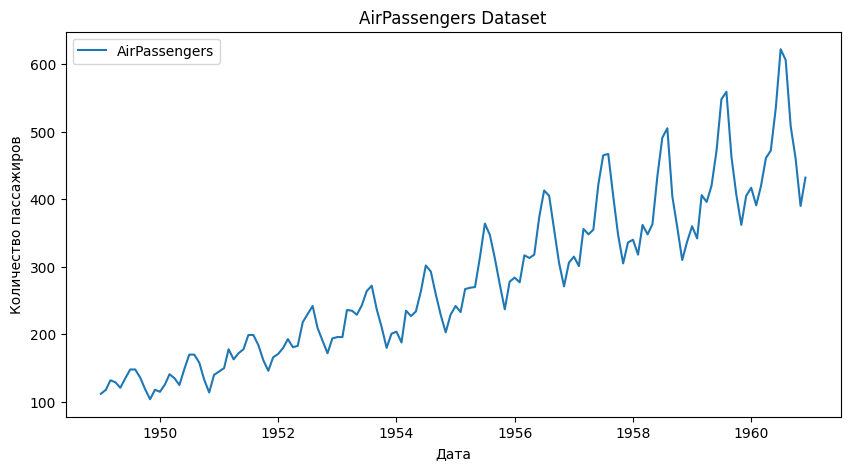

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Визуализация временного ряда
plt.figure(figsize=(10, 5))
plt.plot(data['Passengers'], label="AirPassengers")
plt.title("AirPassengers Dataset")
plt.xlabel("Дата")
plt.ylabel("Количество пассажиров")
plt.legend()
plt.show()

# Проверка структуры данных
print(data.head())
series = data['Passengers'].values

# Реализация модели Хольта-Винтерса

In [4]:
season_length = 12  # Сезонность (12 месяцев)
forecast_horizon = 12  # Прогноз на 1 год

## Предсказание

In [5]:
def holt_winters_forecast(series, alpha, beta, gamma, season_length, forecast_horizon):
    """
    Реализация модели Хольта-Уинтерса.
    """
    n = len(series)
    levels, trends, seasonals = [0] * n, [0] * n, [0] * season_length

    # Инициализация параметров
    levels[0] = series[0]
    trends[0] = series[1] - series[0]
    for i in range(season_length):
        seasonals[i] = series[i] - levels[0]

    forecast = []

    # Основной алгоритм
    for t in range(1, n):
        levels[t] = alpha * (series[t] - seasonals[t % season_length]) + (1 - alpha) * (levels[t - 1] + trends[t - 1])
        trends[t] = beta * (levels[t] - levels[t - 1]) + (1 - beta) * trends[t - 1]
        seasonals[t % season_length] = gamma * (series[t] - levels[t]) + (1 - gamma) * seasonals[t % season_length]

    # Прогноз
    for t in range(forecast_horizon):
        next_level = levels[-1] + (t + 1) * trends[-1]
        forecast.append(next_level + seasonals[(n + t) % season_length])

    return levels[-1], trends[-1], seasonals[-1], forecast

## Подбор гиперпараметров

In [6]:
def tune_holt_winters(series, season_length, forecast_horizon):
    """
    Тюнинг модели Хольта-Уинтерса.
    """
    def loss(params):
        alpha, beta, gamma = params
        _, _, _, forecast = holt_winters_forecast(series, alpha, beta, gamma, season_length, forecast_horizon)
        # Mean Squared Error для оценки качества
        mse = np.mean((series[-forecast_horizon:] - forecast[:forecast_horizon])**2)
        return mse

    # Диапазон параметров
    bounds = [(0.01, 1), (0.01, 1), (0.01, 1)]
    result = minimize(loss, x0=[0.5, 0.5, 0.5], bounds=bounds, method='L-BFGS-B')
    return result.x

## Тюнинг параметров сглаживания

In [8]:
# Тюнинг параметров сглаживания
alpha, beta, gamma = tune_holt_winters(series[:-forecast_horizon], season_length, forecast_horizon)

# Вывод оптимальных параметров
print(f"Оптимальные параметры сглаживания: Alpha = {alpha:.3f}, Beta = {beta:.3f}, Gamma = {gamma:.3f}")

Оптимальные параметры сглаживания: Alpha = 0.010, Beta = 0.100, Gamma = 0.225


## Прогнозирование с оптимальными параметрами

In [9]:
# Прогнозирование на основе оптимальных параметров
last_level, last_trend, last_seasonal, forecast = holt_winters_forecast(
    series[:-forecast_horizon], alpha, beta, gamma, season_length, forecast_horizon
)

# Вывод параметров модели
print(f"Последний уровень: {last_level:.3f}")
print(f"Последний тренд: {last_trend:.3f}")
print(f"Последняя сезонная компонента: {last_seasonal:.3f}")

Последний уровень: 474.322
Последний тренд: 2.510
Последняя сезонная компонента: -84.841


## Построение графика прогноза

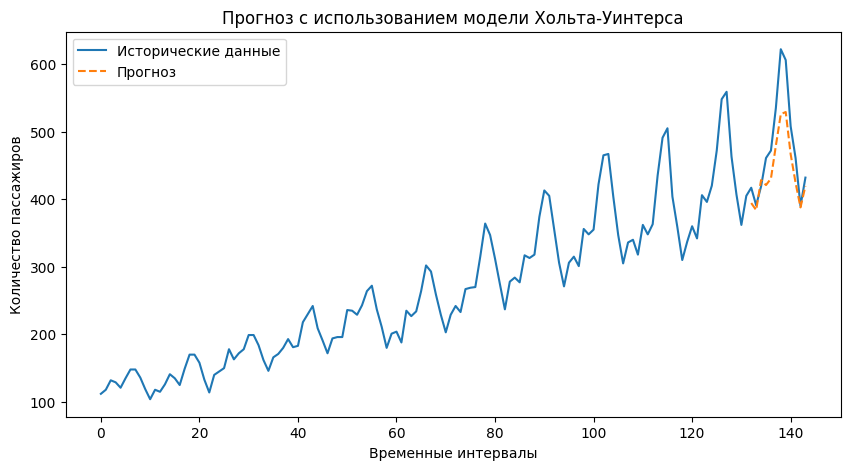

In [10]:
# Визуализация прогноза
plt.figure(figsize=(10, 5))
plt.plot(range(len(series)), series, label="Исторические данные")
plt.plot(range(len(series) - forecast_horizon, len(series)), forecast, label="Прогноз", linestyle="--")
plt.title("Прогноз с использованием модели Хольта-Уинтерса")
plt.xlabel("Временные интервалы")
plt.ylabel("Количество пассажиров")
plt.legend()
plt.show()

## Оценка точности модели

In [11]:
# Оценка точности прогноза
errors = series[-forecast_horizon:] - forecast[:forecast_horizon]
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)

print(f"Средняя абсолютная ошибка (MAE): {mae:.3f}")
print(f"Среднеквадратичная ошибка (MSE): {mse:.3f}")

Средняя абсолютная ошибка (MAE): 36.821
Среднеквадратичная ошибка (MSE): 2119.780


## Визуализация ошибок

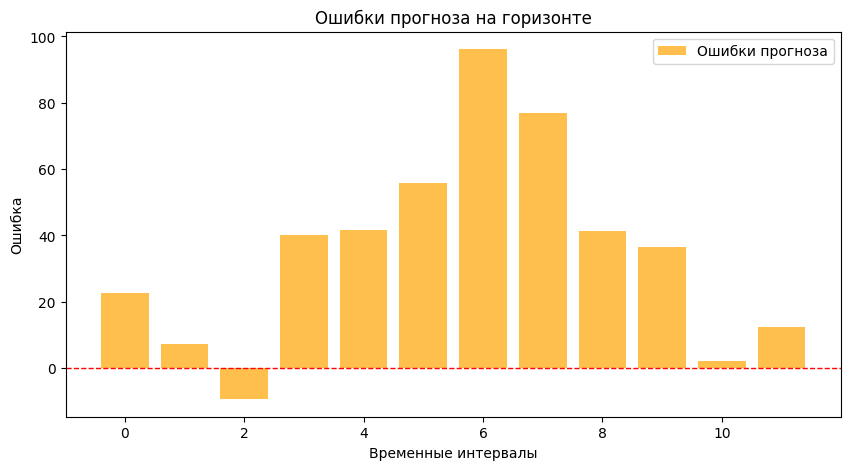

In [12]:
# Визуализация ошибок
plt.figure(figsize=(10, 5))
plt.bar(range(forecast_horizon), errors, color="orange", alpha=0.7, label="Ошибки прогноза")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Ошибки прогноза на горизонте")
plt.xlabel("Временные интервалы")
plt.ylabel("Ошибка")
plt.legend()
plt.show()

# Расширенная версия

Для расширенного варианта добавим возможность автоматического подбора длины сезона (
𝐿
L) вместе с параметрами сглаживания (
𝛼
,
𝛽
,
𝛾
) с использованием методов машинного обучения.

## Добавляем поиск длины сезона в пределах разумного диапазона

In [13]:
def tune_holt_winters_extended(series, forecast_horizon, season_range=(4, 24)):
    """
    Расширенный тюнинг модели Хольта-Уинтерса с подбором длины сезона.
    """
    def loss(params):
        alpha, beta, gamma, season_length = params[0], params[1], params[2], int(params[3])
        _, _, _, forecast = holt_winters_forecast(series, alpha, beta, gamma, season_length, forecast_horizon)
        # Среднеквадратичная ошибка
        mse = np.mean((series[-forecast_horizon:] - forecast[:forecast_horizon])**2)
        return mse

    # Диапазон параметров
    bounds = [
        (0.01, 1),  # Alpha
        (0.01, 1),  # Beta
        (0.01, 1),  # Gamma
        season_range  # Season length
    ]

    # Начальные значения
    initial_guess = [0.5, 0.5, 0.5, 12]  # Alpha, Beta, Gamma, Season length

    # Байесовская оптимизация или метод L-BFGS-B
    result = minimize(loss, x0=initial_guess, bounds=bounds, method='L-BFGS-B')
    optimal_params = result.x
    return optimal_params[0], optimal_params[1], optimal_params[2], int(optimal_params[3])

## Запуск расширенного тюнинга

In [14]:
# Запуск расширенного тюнинга
alpha, beta, gamma, optimal_season_length = tune_holt_winters_extended(series[:-forecast_horizon], forecast_horizon)

# Вывод оптимальных параметров
print(f"Оптимальные параметры сглаживания:")
print(f"Alpha = {alpha:.3f}, Beta = {beta:.3f}, Gamma = {gamma:.3f}")
print(f"Оптимальная длина сезона: {optimal_season_length}")

Оптимальные параметры сглаживания:
Alpha = 0.010, Beta = 0.100, Gamma = 0.225
Оптимальная длина сезона: 12


## Прогнозирование с оптимальными параметрами и длиной сезона

In [15]:
# Прогнозирование
last_level, last_trend, last_seasonal, forecast = holt_winters_forecast(
    series[:-forecast_horizon], alpha, beta, gamma, optimal_season_length, forecast_horizon
)

# Вывод параметров модели
print(f"Последний уровень: {last_level:.3f}")
print(f"Последний тренд: {last_trend:.3f}")
print(f"Последняя сезонная компонента: {last_seasonal:.3f}")

Последний уровень: 474.322
Последний тренд: 2.510
Последняя сезонная компонента: -84.841


In [16]:
# Оценка ошибок прогноза
errors = series[-forecast_horizon:] - forecast[:forecast_horizon]
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)

# Вывод метрик точности
print(f"Средняя абсолютная ошибка (MAE): {mae:.3f}")
print(f"Среднеквадратичная ошибка (MSE): {mse:.3f}")

Средняя абсолютная ошибка (MAE): 36.821
Среднеквадратичная ошибка (MSE): 2119.780


## Визуализация результатов

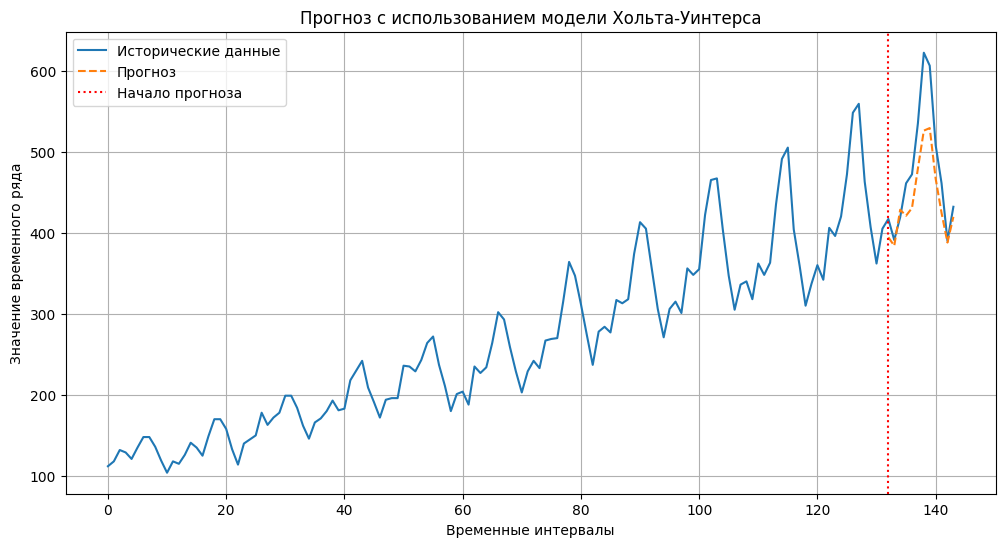

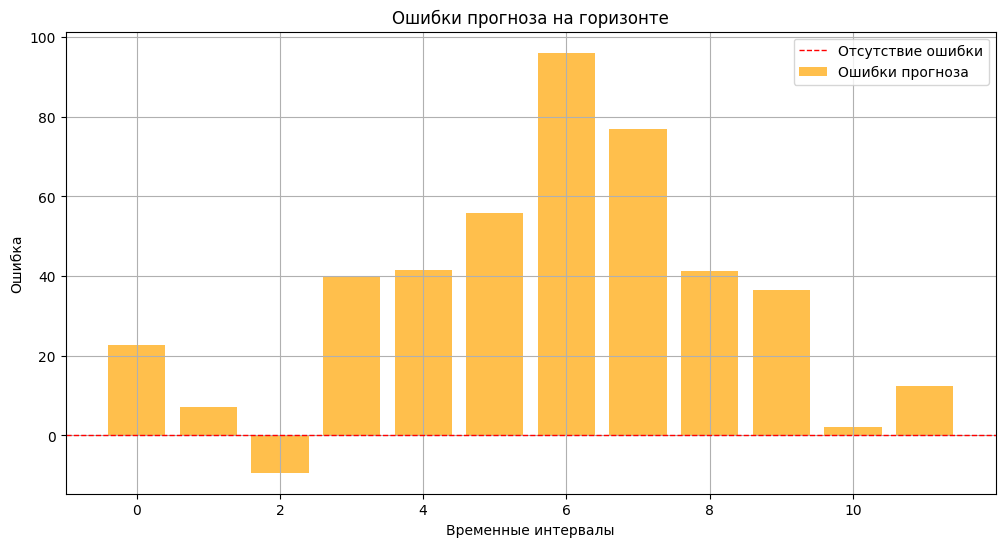

In [17]:
# Визуализация временного ряда и прогноза
plt.figure(figsize=(12, 6))
plt.plot(range(len(series)), series, label="Исторические данные")
plt.plot(range(len(series) - forecast_horizon, len(series)), forecast, label="Прогноз", linestyle="--")
plt.axvline(len(series) - forecast_horizon, color="red", linestyle=":", label="Начало прогноза")
plt.title("Прогноз с использованием модели Хольта-Уинтерса")
plt.xlabel("Временные интервалы")
plt.ylabel("Значение временного ряда")
plt.legend()
plt.grid()
plt.show()

# Визуализация ошибок прогноза
plt.figure(figsize=(12, 6))
plt.bar(range(forecast_horizon), errors, color="orange", alpha=0.7, label="Ошибки прогноза")
plt.axhline(0, color="red", linestyle="--", linewidth=1, label="Отсутствие ошибки")
plt.title("Ошибки прогноза на горизонте")
plt.xlabel("Временные интервалы")
plt.ylabel("Ошибка")
plt.legend()
plt.grid()
plt.show()

## Визуализация подбора длины

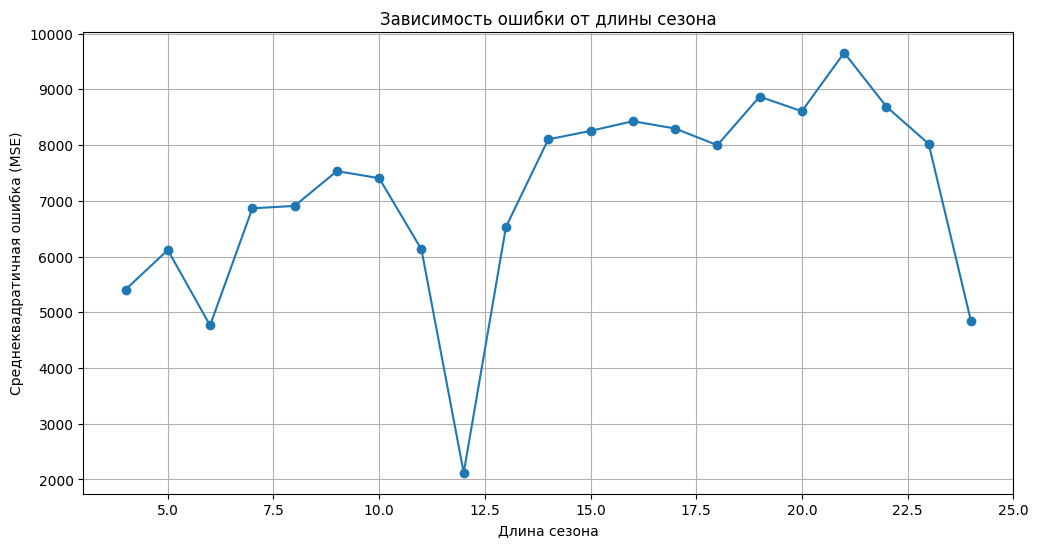

In [18]:
# Проверка различных длин сезонов
season_lengths = range(4, 25)  # Диапазон длин сезонов
errors_by_season_length = []

for season_length in season_lengths:
    _, _, _, forecast = holt_winters_forecast(
        series[:-forecast_horizon], alpha, beta, gamma, season_length, forecast_horizon
    )
    mse = np.mean((series[-forecast_horizon:] - forecast[:forecast_horizon])**2)
    errors_by_season_length.append(mse)

# Визуализация зависимости ошибки от длины сезона
plt.figure(figsize=(12, 6))
plt.plot(season_lengths, errors_by_season_length, marker="o")
plt.title("Зависимость ошибки от длины сезона")
plt.xlabel("Длина сезона")
plt.ylabel("Среднеквадратичная ошибка (MSE)")
plt.grid()
plt.show()